<a href="https://colab.research.google.com/github/ahmadhuzaifa/Stock-Price-Predictor/blob/master/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stock Prediction

The goal of this software is to predict the Apple stock price 260 days into the future using previous data points using Keras and LSTM

##import necessary libraries


In [0]:
import datetime
import pandas as pd
import numpy as np
import pandas_datareader as web
import matplotlib.pyplot as plt

##Get Stock Prices

In [0]:
stock_name = "AAPL"
end_date = datetime.datetime.today()
start_date = datetime.date(end_date.year-100,1,1)

In [0]:
def get_stock_data(stock, start, end):
  df = web.DataReader(stock_name, 'yahoo', start, end)
  df.to_csv(stock_name + '.csv')
  return df

df = get_stock_data(stock_name, start_date, end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1980-12-12,0.515625,0.513393,0.513393,0.513393,117258400.0,0.406782
1980-12-15,0.488839,0.486607,0.488839,0.486607,43971200.0,0.385558
1980-12-16,0.453125,0.450893,0.453125,0.450893,26432000.0,0.357260
1980-12-17,0.464286,0.462054,0.462054,0.462054,21610400.0,0.366103
1980-12-18,0.477679,0.475446,0.475446,0.475446,18362400.0,0.376715
...,...,...,...,...,...,...
2020-03-16,259.079987,240.000000,241.949997,242.210007,80605900.0,242.210007
2020-03-17,257.609985,238.399994,247.509995,252.860001,81014000.0,252.860001
2020-03-18,250.000000,237.119995,239.770004,246.669998,75058400.0,246.669998


##Cleaning the DataFrame
ONLY KEEP CLOSING VALUES


In [0]:
def cleanDF(df):
  df = df.drop(df.columns[[0, 1, 2,4,5]], axis=1)
  df.reset_index(level=0, inplace=True)
  return df

clean_df = cleanDF(df)
clean_df

,Date,Close
0,1980-12-12,0.513393
1,1980-12-15,0.486607
2,1980-12-16,0.450893
3,1980-12-17,0.462054
4,1980-12-18,0.475446
...,...,...
9896,2020-03-16,242.210007
9897,2020-03-17,252.860001
9898,2020-03-18,246.669998
9899,2020-03-19,244.779999


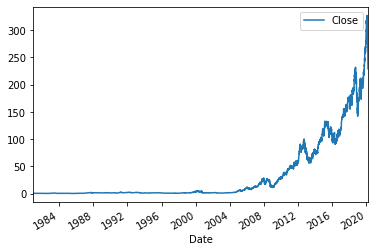

In [0]:
ax = plt.gca()
clean_df.plot(kind='line',x='Date',y='Close',ax=ax)

##FEATURE SCALING


3727


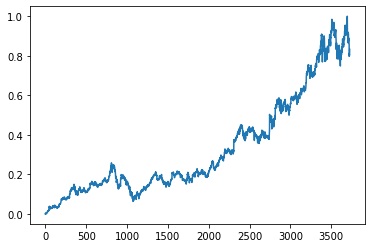

In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
train_size = int(len(clean_df)*0.95)
train_df = clean_df.iloc[:train_size, :]
test_df = clean_df.iloc[train_size:, :]


sc = MinMaxScaler(feature_range = (0,1))
scaled_training_set = sc.fit_transform(train_df.iloc[:, 1:2].values)
print(len(scaled_training_set))
plt.plot(scaled_training_set)

So over here we create an array of arrays which contain the ith stock price given the [i-60: i] array

In [0]:
X_train = []
Y_train = []
for i in range(60, len(scaled_training_set)):
  X_train.append(scaled_training_set[i-60:i,0])
  Y_train.append(scaled_training_set[i,0])
(X_train), (Y_train) = np.array(X_train), np.array(Y_train)

Reshape thet X_train to 3 dimensions

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape= (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 60, 50)            20200     
_________________________________________________________________
dropout_15 (Dropout)         (None, 60, 50)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 50)               

In [0]:
model.fit(X_train, Y_train, epochs=5, batch_size=32)

Epoch 1/5
3667/3667 [==============================] - 26s 7ms/step - loss: 0.0112
Epoch 2/5
3667/3667 [==============================] - 22s 6ms/step - loss: 0.0020
Epoch 3/5
3667/3667 [==============================] - 22s 6ms/step - loss: 0.0018
Epoch 4/5
3667/3667 [==============================] - 22s 6ms/step - loss: 0.0018
Epoch 5/5
3667/3667 [==============================] - 22s 6ms/step - loss: 0.0017


#Testing the Data

In [0]:
test_stock_prices = test_df.iloc[:, 1:2].values

# Number of points to be predicted + 60
predict_numbers = 320 

inputs = clean_df['Close'][len(clean_df) - predict_numbers:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []

for i in range(60, len(inputs)):
  X_test.append(inputs[i-60:i, 0])


X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
prediction = model.predict(X_test)
predicted_inverse = sc.inverse_transform(prediction)

In [0]:
orignal= clean_df['Close'].values
orignal = orignal.reshape(-1,1)

print(predicted_inverse.shape)
y_predicted = list(range(len(orignal)-predict_numbers+60, len(orignal)))

(260, 1)


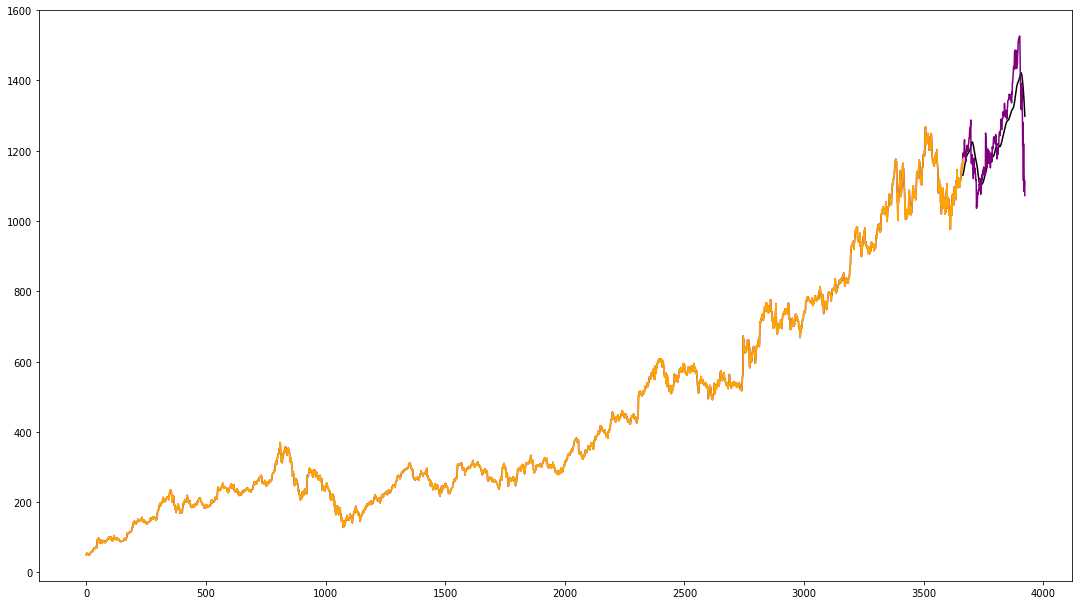

In [0]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_predicted,predicted_inverse, color = "black", label="predicted")
plt.plot(orignal, color = "purple")

plt.plot(orignal[:-predict_numbers+60], color = "orange")

# plt.ylim(-10,350)
# plt.xlim(0,10000)
plt.show()

In [0]:
inputs = orignal
prediction_size = 260
inputs = sc.transform(inputs)
inputs = inputs.reshape(-1,1)
predicted_values = []
predicted_values_y = list(range(len(orignal), len(orignal)+prediction_size))
for i in range(1, prediction_size+1):
  prediction_input = inputs[-60:]
  prediction_input = np.reshape(prediction_input, (1, prediction_input.shape[0], 1))
  prediction_input = np.array(prediction_input)
  inputs = inputs.reshape(-1,1)
  prediction = model.predict(prediction_input)
  inputs = np.append(inputs, prediction)
  predicted_values.append(sc.inverse_transform(prediction))
  fig = plt.gcf()
  fig.set_size_inches(18.5, 10.5)
  predicted_values = np.array(list(predicted_values)).reshape(len(predicted_values),1)
  # inputs = inputs.reshape(-1,1)
  # inputs = sc.inverse_transform(inputs)
  plt.plot(predicted_values_y, predicted_values, color = "black", linestyle=':')

  plt.plot(orignal, color = "orange")
